## Future Sales Forecast

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

#### Load Datasets

In [29]:
items = pd.read_csv('datasets/items.csv')
shops = pd.read_csv('datasets/shops.csv')
sales = pd.read_csv('datasets/sales_train.csv')
items_categories = pd.read_csv('datasets/item_categories.csv')

### Data Processing

In [30]:
# Converting the column 'date' to type 'datetime'.
sales['date'] = sales['date'].apply(lambda d: pd.datetime.strptime(d, '%d.%m.%Y'))

In [31]:
# Create columns 'month' and 'total'.
sales['month'] = sales['date'].apply(lambda s: s.month)
sales['total_value'] = sales['item_price'] * sales['item_cnt_day']

In [50]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,total_value
0,2013-01-02,0,59,22154,999.00,1.0,1,999.00
1,2013-01-03,0,25,2552,899.00,1.0,1,899.00
2,2013-01-05,0,25,2552,899.00,-1.0,1,-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1,1099.00


### Data Analysis and Exploration

In [42]:
sales_per_month = sales.groupby(['month'])
sales_per_month = sales_per_month['item_cnt_day', 'total_value'].sum()

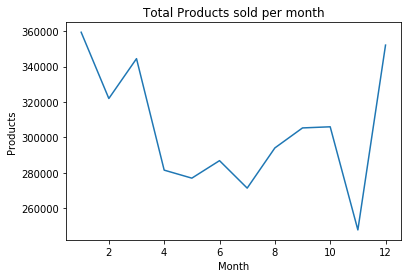

In [45]:
#plt.figure(figsize=(16,8))
plt.title('Total Products sold per month')
plt.xlabel('Month')
plt.ylabel('Products')
plt.plot(sales_per_month['item_cnt_day'])

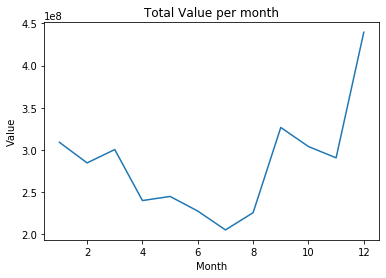

In [46]:
#plt.figure(figsize=(16,8))
plt.title('Total Value per month')
plt.xlabel('Month')
plt.ylabel('Value')
plt.plot(sales_per_month['total_value'])